In [1]:
import sys
import os

import keras
import sklearn as sk
import tensorflow as tf
import platform
import numpy as np
import random

print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

2024-06-10 19:33:56.033961: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-10 19:33:56.057088: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-10 19:33:56.057102: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-10 19:33:56.057835: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-10 19:33:56.061865: I tensorflow/core/platform/cpu_feature_guar

Python Platform: Linux-5.15.146.1-microsoft-standard-WSL2-x86_64-with-glibc2.35
Tensor Flow Version: 2.15.0
Keras Version: 2.15.0

Python 3.11.0rc1 (main, Aug 12 2022, 10:02:14) [GCC 11.2.0]
Scikit-Learn 1.5.0
GPU is available


2024-06-10 19:33:57.433346: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-10 19:33:57.437942: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-10 19:33:57.437971: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
SEED = 42

os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # new flag present in tf 2.0+
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Define the path to your dataset
data_dir = 'data/train/train_six_label'
test_dir = "data/test/test_six_label"
tflite_model_path = 'models/stanger-model.tflite'

# Define the class names
class_names = ["blue", "white", "red", "fail"]

GRAYSCALE = False

image_size = (240, 240)
image_shape = image_size + (1 if GRAYSCALE else 3,)
BATCH_SIZE = 32

# Map folder names to output labels
folder_to_label = {
    "blue": "blue",
    "blue_fail": "fail",
    "red": "red",
    "red_fail": "fail",
    "white": "white",
    "white_fail": "fail"
}

# Create a lookup table for folder names to output labels
keys = tf.constant(list(folder_to_label.keys()))
values = tf.constant([class_names.index(folder_to_label[key]) for key in folder_to_label.keys()])
table = tf.lookup.StaticHashTable(tf.lookup.KeyValueTensorInitializer(keys, values), default_value=3)

# Define another table to map folder names to color indices
color_values = tf.constant([0 if "blue" in key else 1 if "white" in key else 2 for key in folder_to_label.keys()])
color_table = tf.lookup.StaticHashTable(tf.lookup.KeyValueTensorInitializer(keys, color_values), default_value=-1)

@tf.function
def process_label(label):
    # Convert the numeric label to the corresponding folder name
    folder_name = tf.gather(keys, label)
    
    # Look up the output label from the folder name
    mapped_label = table.lookup(folder_name)
    
    # One-hot encode the output label
    one_hot_label = tf.one_hot(mapped_label, len(class_names))
    
    # Look up the color index from the folder name
    color_index = color_table.lookup(folder_name)
    
    return one_hot_label, color_index

# Load the dataset
dataset = image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=image_size,
    shuffle=True,
    color_mode='grayscale' if GRAYSCALE else 'rgb'
)

test_ds = image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=image_size,
    shuffle=True,
    color_mode='grayscale' if GRAYSCALE else 'rgb'
)

# Process the dataset
@tf.function
def process_image_label(image, label):
    one_hot_label, color_index = process_label(label)
    return {"image_input": image, "color_index_input": color_index}, one_hot_label

dataset = dataset.map(process_image_label)

# Split dataset into training and validation
val_size = int(0.2 * len(list(dataset)))
train_ds = dataset.skip(val_size)
val_ds = dataset.take(val_size)

test_ds = test_ds.map(process_image_label)

2024-06-10 19:33:57.481789: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-10 19:33:57.481841: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-10 19:33:57.481860: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-10 19:33:57.624963: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-10 19:33:57.625001: I external/local_xla/xla/stream_executor

Found 840 files belonging to 6 classes.


In [ ]:
# Data Augmentation Pipeline

data_augmentation = tf.keras.Sequential([
    # tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    # tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.RandomBrightness(0.1),
])

AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  if shuffle:
    ds = ds.shuffle(1000)

  # Use data augmentation only on the training set.
  if augment:
        ds = ds.map(lambda x, y: ({"image_input": data_augmentation(x["image_input"], training=True), "color_index_input": x["color_index_input"]}, y), num_parallel_calls=AUTOTUNE)
    

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

train_ds = prepare(train_ds, shuffle=True, augment=True)

In [ ]:
for x, y in train_ds.take(1):
    # Gather all unique color indices
    color_indices = tf.unique(tf.reshape(x["color_index_input"], [-1]))[0]
    print(color_indices)

tf.Tensor([2 1 0], shape=(3,), dtype=int32)


In [ ]:
from tensorflow.keras.layers import Input, Flatten, Dense, Concatenate, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB1, MobileNetV2, InceptionV3, EfficientNetV2L, EfficientNetB0

# Define the number of classes
num_classes = len(class_names)

def rgb_to_grayscale(x):
    """
    Convert RGB images to grayscale.
    """
    return tf.image.rgb_to_grayscale(x)

# Define the input shapes
color_index_input_shape = ()

def create_model(image_shape):
    
    # Define the image input
    image_input = Input(shape=image_shape, name='image_input')

    # Load EfficientNetB1 pre-trained on ImageNet without the top classification layer
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=image_input, )
    # base_model = MobileNetV2(weights='imagenet', 
    #                          include_top=False, 
    #                          input_tensor=image_input, 
    #                          input_shape=image_shape, 
    #                          pooling='avg',
    #                          alpha=1.4,
    #                          depth_multiplier=2,
    #                          )

    # base_model = InceptionV3(weights='imagenet',
    #                             include_top=False,
    #                             input_tensor=image_input,
    #                             input_shape=image_shape,
    #                             pooling='avg')

    # Freeze the base model layers so they are not updated during training
    base_model.trainable = False

    # Define the color index input
    color_index_input = Input(shape=color_index_input_shape, name='color_index_input')

    # Flatten the output of the base model
    x = Flatten()(base_model.output)

    # Color index processing through embedding layer
    embedding_dim = 8
    color_embedding = Embedding(input_dim=4, output_dim=embedding_dim)(color_index_input)
    color_embedding = Flatten()(color_embedding)

    # Concatenate image features and color embedding
    combined = Concatenate()([x, color_embedding])

    # Fully connected layers
    combined = Dense(256, activation='relu')(combined)
    combined = Dense(128, activation='relu')(combined)
    output = Dense(num_classes, activation='softmax')(combined)

    # Define the model
    model = Model(inputs=[image_input, color_index_input], outputs=output)

    # Compile the model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

model = create_model(image_shape)

model.summary()

16705208/16705208 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 240, 240, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 240, 240, 3)          0         ['image_input[0][0]']         
                                                                                                  
 normalization (Normalizati  (None, 240, 240, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     

In [ ]:
# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=3, verbose=0, mode='auto',
    min_delta=0.0001, cooldown=0, min_lr=0
)

In [ ]:
H = model.fit(train_ds, epochs=40, validation_data=val_ds, callbacks=[early_stopping, reduce_lr])

Epoch 1/40


2024-06-10 19:28:31.880399: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2024-06-10 19:28:32.874468: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f31d81b1070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-10 19:28:32.874499: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 SUPER, Compute Capability 8.9
2024-06-10 19:28:32.883370: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1718047712.940789      97 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


22/22 [==============================] - 7s 90ms/step - loss: 6.0552 - accuracy: 0.5000 - val_loss: 0.7507 - val_accuracy: 0.7437 - lr: 0.0010
Epoch 2/40
22/22 [==============================] - 2s 47ms/step - loss: 1.6524 - accuracy: 0.7191 - val_loss: 0.6106 - val_accuracy: 0.8375 - lr: 0.0010
Epoch 3/40
22/22 [==============================] - 2s 44ms/step - loss: 1.0534 - accuracy: 0.7779 - val_loss: 2.1072 - val_accuracy: 0.5750 - lr: 0.0010
Epoch 4/40
22/22 [==============================] - 2s 53ms/step - loss: 1.1283 - accuracy: 0.7735 - val_loss: 0.5281 - val_accuracy: 0.8062 - lr: 0.0010
Epoch 5/40
22/22 [==============================] - 2s 46ms/step - loss: 0.8552 - accuracy: 0.8206 - val_loss: 0.8451 - val_accuracy: 0.8188 - lr: 0.0010
Epoch 6/40
22/22 [==============================] - 2s 48ms/step - loss: 0.7256 - accuracy: 0.8279 - val_loss: 0.4672 - val_accuracy: 0.8562 - lr: 0.0010
Epoch 7/40
22/22 [==============================] - 2s 45ms/step - loss: 0.6012 - accur

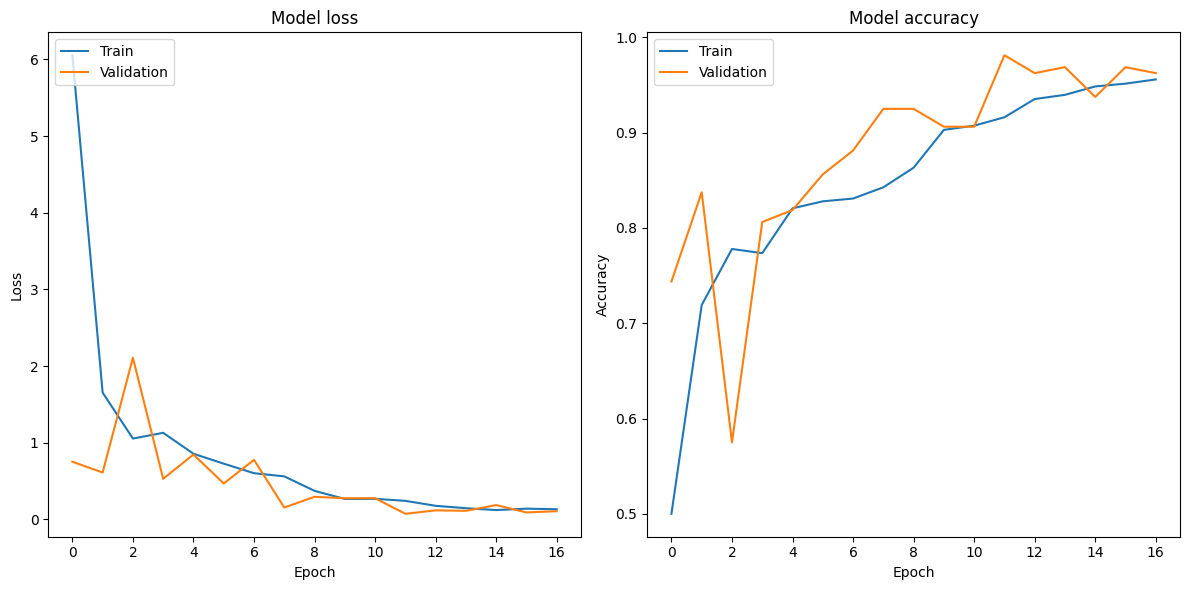

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Plot training & validation loss values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_history(H)

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_ds)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

12/12 [==============================] - 0s 25ms/step - loss: 0.2547 - accuracy: 0.9389
Test Accuracy: 0.9389
Test Loss: 0.2547


In [ ]:
!!pip install seaborn

['Collecting seaborn',
 '  Downloading seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)',
 'Requirement already satisfied: numpy!=1.24.0,>=1.20 in /usr/local/lib/python3.11/dist-packages (from seaborn) (1.26.2)',
 'Requirement already satisfied: pandas>=1.2 in /usr/local/lib/python3.11/dist-packages (from seaborn) (2.2.2)',
 'Requirement already satisfied: matplotlib!=3.6.1,>=3.4 in /usr/local/lib/python3.11/dist-packages (from seaborn) (3.8.2)',
 'Requirement already satisfied: contourpy>=1.0.1 in /usr/local/lib/python3.11/dist-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (1.2.0)',
 'Requirement already satisfied: cycler>=0.10 in /usr/local/lib/python3.11/dist-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (0.12.1)',
 'Requirement already satisfied: fonttools>=4.22.0 in /usr/local/lib/python3.11/dist-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (4.45.0)',
 'Requirement already satisfied: kiwisolver>=1.3.1 in /usr/local/lib/python3.11/dist-packages (from matplotlib!=3.6.1,>=

# Evaluation

1/1 [==============================] - 1s 716ms/step
              precision    recall  f1-score   support

           0       0.94      0.85      0.89        60
           1       0.98      0.97      0.97        60
           2       0.89      0.97      0.93        60
           3       0.94      0.95      0.94       180

    accuracy                           0.94       360
   macro avg       0.94      0.93      0.94       360
weighted avg       0.94      0.94      0.94       360



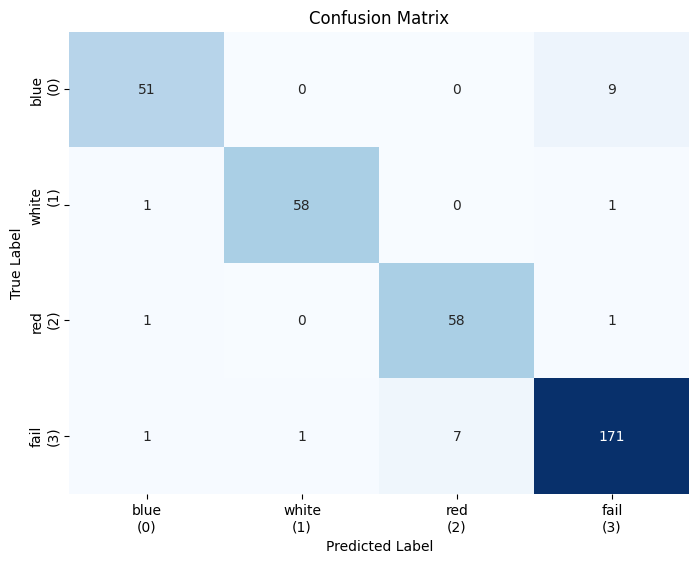

In [ ]:
# Import necessary libraries
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Initialize lists for true and predicted labels
y_true = []
y_pred = []

# Iterate through the test dataset to collect true and predicted labels
for x, y in test_ds:
    y_true.extend(y.numpy())
    y_pred.extend(model.predict(x).argmax(axis=1))

# Convert y_true from one-hot encoding to class indices
y_true = np.argmax(y_true, axis=1)

# Generate the classification report as a dictionary
report = classification_report(y_true, y_pred)
print(report)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)

# Set tick labels to class names
tick_labels = [f'{class_names[i]}\n({i})' for i in range(len(class_names))]
plt.xticks(ticks=np.arange(len(class_names))+0.5, labels=tick_labels)
plt.yticks(ticks=np.arange(len(class_names))+0.5, labels=tick_labels)

plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [ ]:
# Compute Recall for each class
recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
recall_dict = dict(zip(class_names, recall))
print("Recall for each class:")
print(recall_dict)

Recall for each class:
{'blue': 0.85, 'white': 0.9666666666666667, 'red': 0.9666666666666667, 'fail': 0.95}


In [ ]:
# Compute Precision for each class
precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
precision_dict = dict(zip(class_names, precision))
print("\nPrecision for each class:")
print(precision_dict)


Precision for each class:
{'blue': 0.9444444444444444, 'white': 0.9830508474576272, 'red': 0.8923076923076924, 'fail': 0.9395604395604396}


1/1 [==============================] - 0s 19ms/step


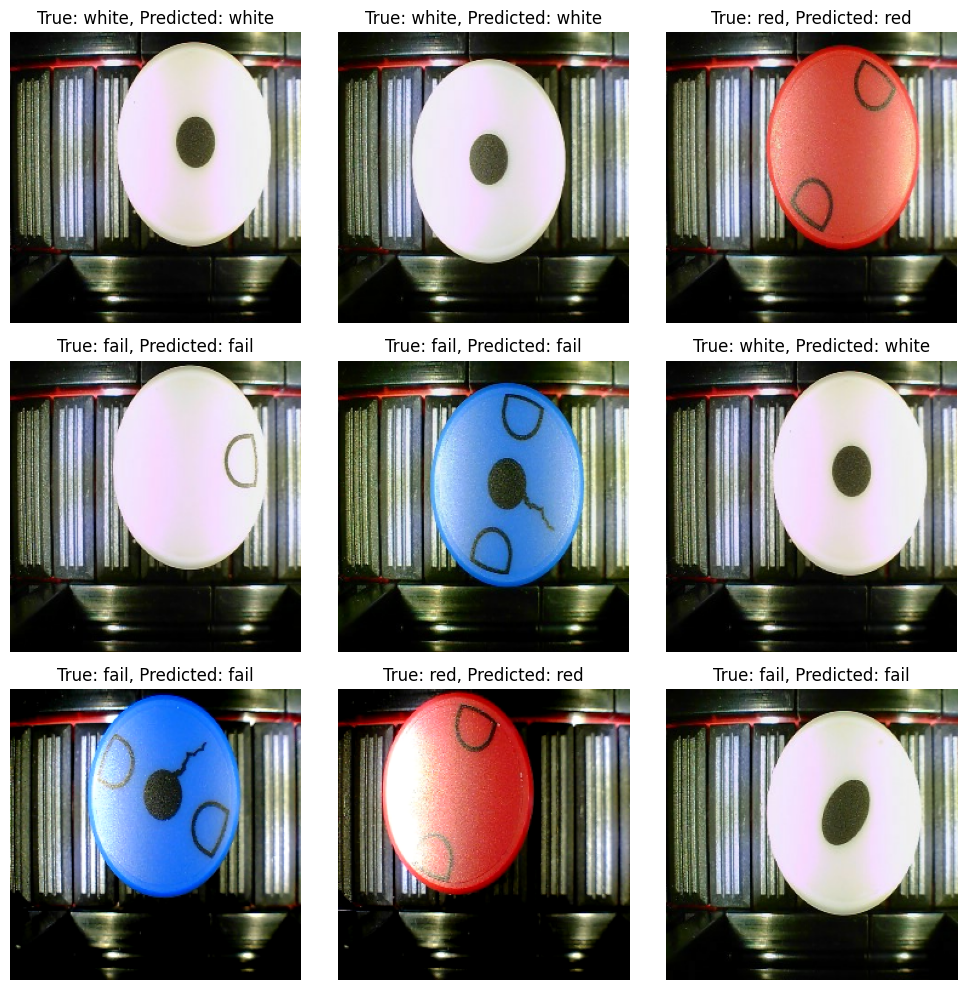

In [ ]:
for x, y in test_ds.take(1):
    # Perform inference on the test data
    predictions = model.predict(x)
    # Get the class with the highest probability
    predicted_classes = np.argmax(predictions, axis=1)
    # Get the true classes
    true_classes = np.argmax(y, axis=1)

    # Display the images with the true and predicted classes
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(x["image_input"][i].numpy().astype("uint8"))
        plt.title(f"True: {class_names[true_classes[i]]}, Predicted: {class_names[predicted_classes[i]]}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
# Convert to TFLite

# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp_jcczavk/assets


INFO:tensorflow:Assets written to: /tmp/tmp_jcczavk/assets
2024-06-10 19:29:22.179643: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-06-10 19:29:22.179677: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-06-10 19:29:22.179935: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp_jcczavk
2024-06-10 19:29:22.196077: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-06-10 19:29:22.196089: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp_jcczavk
2024-06-10 19:29:22.226967: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-06-10 19:29:22.242261: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-06-10 19:29:22.622340: I tensorflow/cc/saved_model/loader.cc:217] Running initializatio

In [ ]:
# !!pip install tflite_runtime

In [ ]:
from TFLiteModel import TFLiteModel

# Load the TFLite model and define the class names

tflite_model = TFLiteModel(tflite_model_path)

for x, y in test_ds.take(1):
    
    image = x["image_input"][0].numpy()
    color = x["color_index_input"][0].numpy()

    image = image.astype(np.float32) # Convert to FLOAT32

    # Convert color to float32
    color = color.astype(np.float32)
    # Convert color to 1D array
    color = np.expand_dims(color, axis=0)
    # Convert image to 4D array
    image = np.expand_dims(image, axis=0)

    # Perform inference using the TFLite model
    predictions = tflite_model.predict(color, image)

    print(predictions)

    # Get the class with the highest probability
    predicted_class = np.argmax(predictions)

    # Display the image with the predicted class
    plt.figure()
    plt.imshow(image[0].astype("uint8"))
    plt.title(f"Predicted: {class_names[predicted_class]}")
    plt.axis("off")
    plt.show()


ModuleNotFoundError: No module named 'tflite_runtime'

In [ ]:

# Collect the predictions
predictions = []
test_labels = []

for x, y in test_ds:
    for i in range(len(y)):
        image = x["image_input"][i].numpy()
        color = x["color_index_input"][i].numpy()

        image = image.astype(np.float32) # Convert to FLOAT32

        # Convert color to float32
        color = color.astype(np.float32)
        # Convert color to 1D array
        color = np.expand_dims(color, axis=0)
        # Convert image to 4D array
        image = np.expand_dims(image, axis=0)


        output = tflite_model.predict(color, image)


        predictions.append(output)
        test_labels.append(y[i])

# Calculate the accuracy
correct = 0
total = len(test_labels)

for i in range(total):
    if np.argmax(predictions[i]) == np.argmax(test_labels[i]):
        correct += 1

tflite_accuracy = correct / total

print(f"TFLite Model Accuracy: {tflite_accuracy:.4f}")


TFLite Model Accuracy: 0.9417


In [ ]:
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"TFLite Model Accuracy: {tflite_accuracy:.4f}")

Test Accuracy: 0.9417
TFLite Model Accuracy: 0.9417
